In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [2]:
dataset_path = "/kaggle/input/final-dataset/GOLD_XYZ_OSC_POSITIVE_COMBINED.hdf5"

In [3]:
import numpy as np
import torch.nn as nn
import torch.optim as optim
import h5py
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.utils.data import DataLoader, TensorDataset
import os, time
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
with h5py.File(dataset_path, 'r') as f:
    X = f['X'][:]
    Y = f['Y'][:]
    Z = f['Z'][:]

In [5]:
# Compute min and max along axis 1 (1024 samples per instance)
X_min = np.min(X, axis=1, keepdims=True)
X_max = np.max(X, axis=1, keepdims=True)

# print(X_min, X_max)

# # Avoid division by zero
X_range = X_max - X_min
X_range[X_range == 0] = 1  # If min == max, set range to 1 to avoid NaN

# # Normalize to [-1, 1]
X = 2 * (X - X_min) / X_range - 1
print(X.shape)

(779688, 1024, 2)


In [6]:
import gc

gc.collect()

0

In [7]:
from sklearn.model_selection import train_test_split


snr_levels = np.append(np.arange(0, 31, 2), 9999)
modulation_schemes = range(9)

test_size = 0.1
valid_size = 0.2

train_indices = []
validation_indices = []
test_indices = []

for modulation_scheme in modulation_schemes:
    indices = np.where(Y == modulation_scheme)[0]
    # now for these indices find each SNR indices in snr_levels
    for snr in snr_levels:
        snr_indices = np.where(Z[indices] == snr)[0]

        # split into train+valid and test first
        train_valid, test = train_test_split(
            snr_indices, test_size=test_size, stratify=Z[indices][snr_indices], random_state=0
        )

        # further split train_valid into train and validation sets
        train, valid = train_test_split(
            train_valid, test_size=valid_size / (1 - test_size), stratify=Z[indices][train_valid], random_state=42
        )

        train_indices.extend(indices[train])
        validation_indices.extend(indices[valid])
        test_indices.extend(indices[test])

# convert lists to numpy arrays for shuffling
train_indices = np.array(train_indices)
validation_indices = np.array(validation_indices)
test_indices = np.array(test_indices)

# shuffle the indices
np.random.shuffle(train_indices)
np.random.shuffle(validation_indices)
np.random.shuffle(test_indices)


print("Train size: ", len(train_indices))
print("Validation size: ", len(validation_indices))
print("Test size: ", len(test_indices))

print(train_indices[:10])
print(validation_indices[:10])
print(test_indices[:10])

Train size:  545598
Validation size:  156060
Test size:  78030
[  4479 605989 377622 167511 290217 249818 721926 283866 102685  17388]
[611815 705713 281805 717927 738381 512711 306635 174393 279737 630390]
[757112 551296 530078 224954 128073 173639 349075 674441 186349 574283]


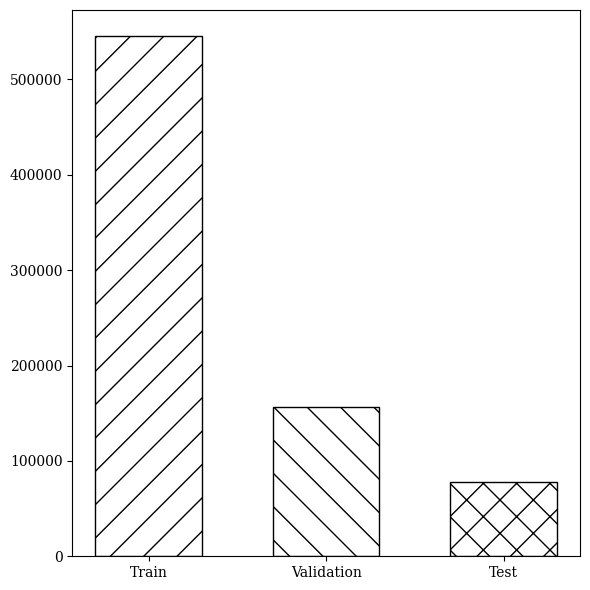

In [8]:
# ############## Histogram of the classes in the train, validation and test sets ##############

import matplotlib.pyplot as plt


train_classes = Y[train_indices]
validation_classes = Y[validation_indices]
test_classes = Y[test_indices]


# Count occurrences for each dataset
train_count = len(train_classes)
validation_count = len(validation_classes)
test_count = len(test_classes)

# Data for the bar chart
datasets = ['Train', 'Validation', 'Test']
counts = [train_count, validation_count, test_count]

# np.save('datasets.npy', datasets)
# np.save('counts.npy', counts)

# datasets = np.load('datasets.npy')
# counts = np.load('counts.npy')

# Create the bar chart
fig, ax = plt.subplots(figsize=(6, 6))
bar_width = 0.6
ax.bar(datasets, counts, width=bar_width, color='white', edgecolor='black', hatch=['/', '\\', 'x'])

# Aesthetic improvements
# ax.set_title("Sample Counts in Train, Validation, and Test Sets", fontsize=14)
# ax.set_xlabel("Dataset")
# ax.set_ylabel("Count")

plt.savefig("dataset_dist.pdf", format="pdf")
plt.tight_layout()
plt.show()

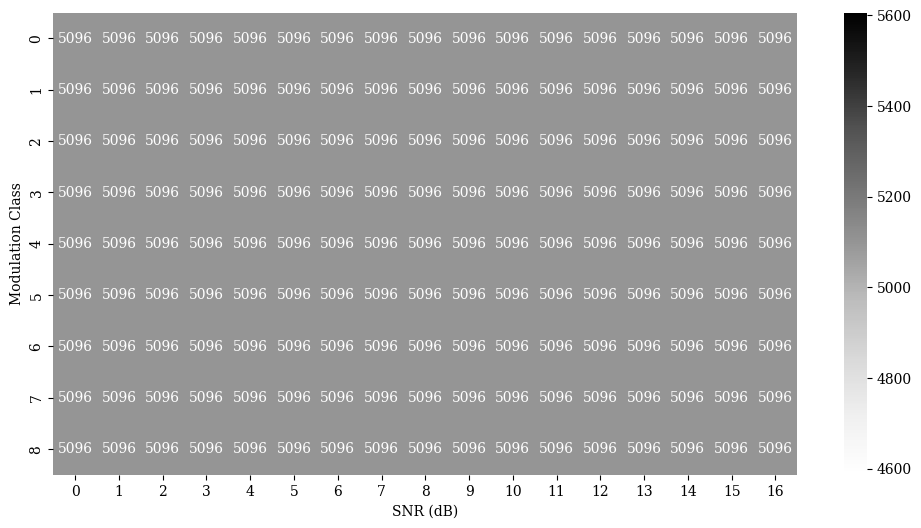

In [9]:
modulation_classes = np.unique(Y)
snr_levels = np.unique(Z)
heatmap_data = np.zeros((len(modulation_classes), len(snr_levels)))


for modulation_class in modulation_classes:
    class_indices = np.where(Y == modulation_class)
    for i, snr in enumerate(snr_levels):
        snr_indices = np.where(Z[class_indices] == snr)
        count = len(snr_indices[0])
        heatmap_data[modulation_class, i] = count

df_heatmap = pd.DataFrame(heatmap_data, index=modulation_classes, columns=snr_levels)
# df_heatmap.to_csv("modulation_vs_snr_heatmap_data.csv")
np.save('heatmap.npy', df_heatmap)
df_heatmap = np.load('heatmap.npy')
plt.figure(figsize=(12, 6))
sns.heatmap(df_heatmap, annot=True, cmap="Greys", fmt="g")
# plt.title("Modulation Class vs SNR Heatmap (Instance Counts)")
plt.xlabel("SNR (dB)")
plt.ylabel("Modulation Class")
# plt.savefig("Distribution Plot.pdf", format="pdf")

plt.show()

In [10]:
# in each instance of X we have 1024 samples but our network takes only 224 samples, so we will make a window of 224 samples
# we will get 8 sequences from each instance of X
# we have to make sure that the sequences are from the same instance of X and we should not mix sequences from different instances of X
# we will also make sure that the sequences are from the same modulation scheme and the same SNR level


def windowing_function(input_data):

    if input_data.shape != (1024, 2):
        raise ValueError("Input data must have shape (1024, 2).")

    window_size = 224
    overlap = window_size // 2
    step_size = window_size - overlap
    output_sequences = []

    for i in range(0, 1024 - window_size, step_size):
        output_sequences.append(input_data[i:i + window_size])

    return np.array(output_sequences)




In [11]:
def process_indices(indices):
    X_seq = []
    Y_seq = []

    for idx in indices:
        seq = windowing_function(X[idx])
        X_seq.append(seq)
        Y_seq.append(np.full(len(seq), Y[idx], dtype=np.float16))

    return np.concatenate(X_seq, axis=0, dtype=np.float16), np.concatenate(Y_seq, axis=0)

# Process training, validation, and test sets
# X_train, Y_train = process_indices(train_indices)
# X_valid, Y_valid = process_indices(validation_indices)
X_test, Y_test = process_indices(test_indices)

In [12]:
# def amplitude_phase_seq_batch(iq_seq):
#     amplitude = np.sqrt(np.sum(np.square(iq_seq), axis=2, keepdims=True))
#     phase = np.arctan2(iq_seq[:, :, 1], iq_seq[:, :, 0])[..., np.newaxis]
#     return np.concatenate([iq_seq, amplitude, phase], axis=2)

# X_train = amplitude_phase_seq_batch(X_train)
# X_valid = amplitude_phase_seq_batch(X_valid)
# X_test = amplitude_phase_seq_batch(X_test)

def amplitude_phase_seq_batch(iq_seq, device):
    if isinstance(iq_seq, np.ndarray):
        iq_seq = torch.from_numpy(iq_seq).to(device, dtype=torch.float32)
    else:
        iq_seq = iq_seq.to(device, dtype=torch.float32)
    squared = iq_seq ** 2
    amplitude = torch.sqrt(torch.sum(squared, dim=2, keepdim=True))
    phase = torch.atan2(iq_seq[..., 1], iq_seq[..., 0]).unsqueeze(-1)
    return torch.cat((iq_seq, amplitude, phase), dim=2)

In [13]:
import gc

gc.collect()

16372

In [14]:
def data_preparation_alexnet(input_data, device):
    iq_channel = input_data[:, :, :2] # Shape: (32, 224, 2)
    amp_channel = input_data[:, :, 2:3]  # Shape: (32, 224, 1)
    phase_channel = input_data[:, :, 3:]  # Shape: (32, 224, 1)

    # print(iq_channel.shape)
    iq_channel = iq_channel.repeat(1, 1, 112)
    amp_channel = amp_channel.repeat(1, 1, 224)
    phase_channel = phase_channel.repeat(1, 1, 224)

    # adding new dimension for channel to make the shape (8, 3, 224, 224)
    input_tensor = torch.stack([iq_channel, amp_channel, phase_channel], dim=1)

    input_tensor = input_tensor.to(device)
    return input_tensor


def data_preparation(initial_batch_data, device):
    iq_channel = initial_batch_data[:, :, :2]  # Shape: (32, 224, 2)
    amp_channel = initial_batch_data[:, :, 2:3]  # Shape: (32, 224, 1)
    phase_channel = initial_batch_data[:, :, 3:]  # Shape: (32, 224, 1)

    iq_channel = iq_channel.repeat(1, 1, 112)
    amp_channel = amp_channel.repeat(1, 1, 224)
    phase_channel = phase_channel.repeat(1, 1, 224)

    input_tensor = torch.stack([iq_channel, amp_channel, phase_channel], dim=1)
    input_tensor = input_tensor.to(device)
    return input_tensor


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

class AlexNetModified(nn.Module):
    def __init__(self):
        super(AlexNetModified, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True)
        )
        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = self.features(x)
        x = self.global_avg_pooling(x)
        # x = torch.flatten(x, 1)
        return x


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size,
                            num_layers, batch_first=True)
        # self.fc1 = nn.Linear(hidden_size * 8, 512)
        # self.fc2 = nn.Linear(512, 256)
        # self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(
            0), self.hidden_size, device=x.device).detach()
        c0 = torch.zeros(self.num_layers, x.size(
            0), self.hidden_size, device=x.device).detach()
        out, _ = self.lstm(x, (h0, c0))
        out = out.reshape(out.size(0), -1)  # Flatten all hidden states
        # out = F.relu(self.fc1(out))
        # out = F.relu(self.fc2(out))
        # out = self.fc3(out)
        return out



class FullyConnectedLayer(nn.Module):
    def __init__(self, input_size, drop_factor, output_size):
        super(FullyConnectedLayer, self).__init__()
        self.l1 = nn.Linear(input_size, 512)
        self.dropout1 = nn.Dropout(drop_factor)
        self.l2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(drop_factor)
        self.l3 = nn.Linear(256, output_size)

    def forward(self, x):
        x = F.leaky_relu(self.l1(x))
        x = self.dropout1(x)
        x = F.leaky_relu(self.l2(x))
        x = self.dropout2(x)
        x = self.l3(x)
        return x

Device:  cuda


In [16]:

params = {
    "input_size": 256,
    "hidden_size": 256,
    "num_layers": 2,
    "num_classes": 9,
    "num_epochs": 10,
    "batch_size": 32,
    "num_seq": 8,
    "log_interval": 10,
    "hidden_layer1": 512,
    "hidden_layer2": 256,
    "dropout_factor": 0.6,
    "learning_rate": 0.00015
}

In [17]:
# convert X_train, Y_train to tensor
# X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
# Y_train = torch.tensor(Y_train, dtype=torch.float32).to(device)

X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
Y_test = torch.tensor(Y_test, dtype=torch.float32).to(device)

# X_valid = torch.tensor(X_valid, dtype=torch.float32).to(device)
# Y_valid = torch.tensor(Y_valid, dtype=torch.float32).to(device)

In [18]:
class CustomDataloader(DataLoader):
    def __init__(self, dataset, batch_size, num_seq, shuffle=True):
        self.X = dataset.tensors[0]  # Input data
        self.Y = dataset.tensors[1]  # Labels
        self.batch_size = batch_size*num_seq
        self.num_seq = num_seq
        self.shuffle = shuffle
        self.indices = np.arange(len(self.X))
        if self.shuffle:
            np.random.shuffle(self.indices)


    def __iter__(self):
        self.i = 0
        return self

    def __next__(self):
        if self.i >= len(self.X):
            raise StopIteration

        # Get indices for the batch
        indices = self.indices[self.i:self.i + self.batch_size]
        self.i += self.batch_size

        batch_X = []
        batch_Y = []

        for index in indices:
            seq = self.X[index]  # Get the sequence data
            batch_X.append(seq)

            # Only add corresponding labels for the sequences indexed by multiple of `num_seq`
            if index % self.num_seq == 0:
                batch_Y.append(self.Y[index])

        # Stack the sequences into one tensor for X and Y
        # Shape: [batch_size, seq_len, 224, 4]
        batch_X_tensor = torch.stack(batch_X)
        # Shape: [batch_size // num_seq, label_dim]
        batch_Y_tensor = torch.stack(batch_Y)

        # Move tensors to the correct device
        return batch_X_tensor.to(device), batch_Y_tensor.to(device)

    def __len__(self):
        return len(self.X) // self.batch_size


# train_data = TensorDataset(X_train, Y_train)
# train_dataloader = CustomDataloader(train_data, batch_size=params["batch_size"], shuffle=False, num_seq= params["num_seq"])

# valid_data = TensorDataset(X_valid, Y_valid)
# valid_dataloader = CustomDataloader(
#     valid_data, batch_size=params["batch_size"], shuffle=False, num_seq=params["num_seq"])


test_data = TensorDataset(X_test, Y_test)
test_dataloader = CustomDataloader(test_data, batch_size=params["batch_size"], shuffle=False, num_seq = params["num_seq"])

In [19]:
for batch_X, batch_Y in test_dataloader:
    print(batch_X.shape, batch_Y.shape)
    print(batch_Y)
    break

torch.Size([256, 224, 2]) torch.Size([32])
tensor([4., 5., 5., 2., 1., 2., 4., 8., 2., 7., 7., 5., 2., 4., 7., 1., 5., 6.,
        3., 5., 5., 0., 0., 0., 4., 6., 5., 5., 1., 7., 7., 8.],
       device='cuda:0')


In [20]:
ALEX_model = AlexNetModified().to(device)

In [21]:
LSTM_model = LSTMModel(params["input_size"], params["hidden_size"], params["num_layers"]).to(device)

In [22]:
FC_model = FullyConnectedLayer(params["hidden_size"] * params["num_seq"], params["dropout_factor"], params["num_classes"]).to(device)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

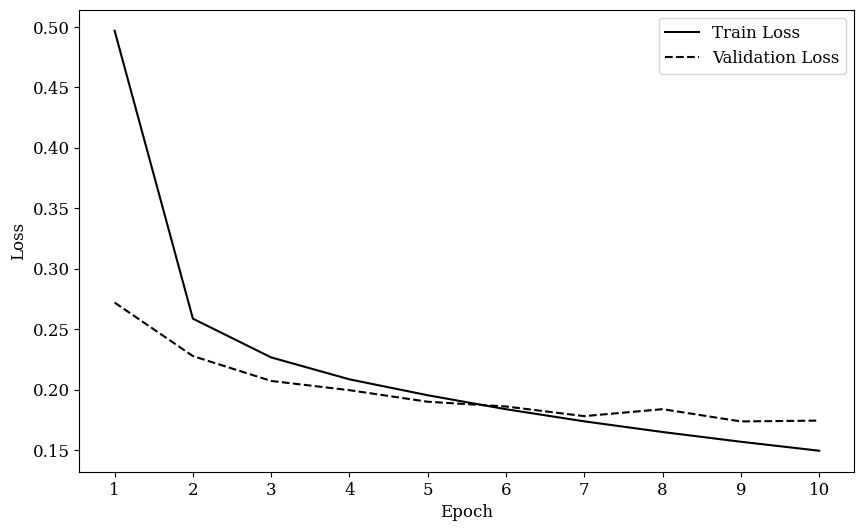

In [23]:
train_loss_history = np.load('/kaggle/input/new-tuned/train_loss_history.npy')
val_loss_history = np.load('/kaggle/input/new-tuned/val_loss_history.npy')
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, 11), y=train_loss_history, label='Train Loss', linestyle='-', color="black")
sns.lineplot(x=range(1, 11), y=val_loss_history, label='Validation Loss', linestyle='--', color="black")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xticks(range(1, 11))
plt.legend(fontsize=12)
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

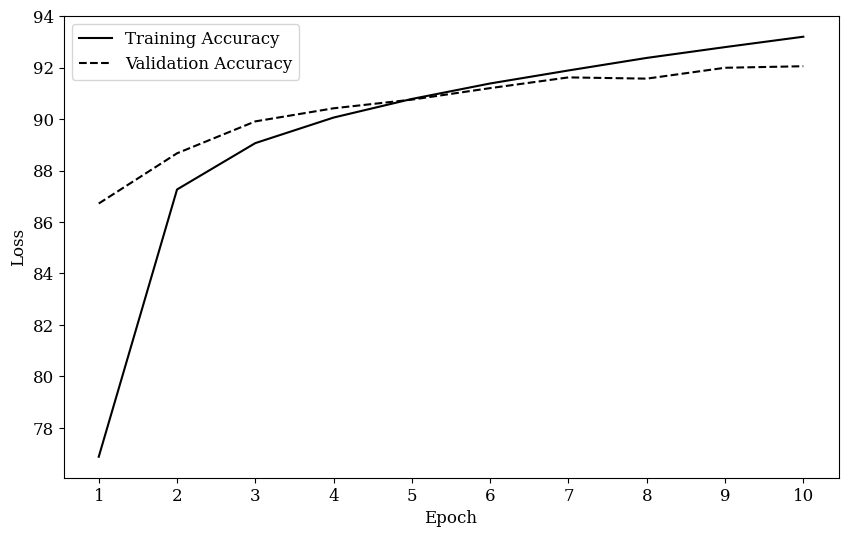

In [24]:
train_acc_history = np.load('/kaggle/input/new-tuned/train_acc_history.npy')
val_acc_history = np.load('/kaggle/input/new-tuned/val_acc_history.npy')
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, 11), y=train_acc_history, label='Training Accuracy', linestyle='-', color="black")
sns.lineplot(x=range(1, 11), y=val_acc_history, label='Validation Accuracy', linestyle='--', color="black")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xticks(range(1, 11))
plt.legend(fontsize=12)
plt.show()

In [25]:
# best saved model
best_model_path = '/kaggle/input/new-tuned/best_model_epoch_9.pth'
checkpoint = torch.load(best_model_path, weights_only=True)

ALEX_model.load_state_dict(checkpoint['ALEX_model_state_dict'])
LSTM_model.load_state_dict(checkpoint['LSTM_model_state_dict'])
FC_model.load_state_dict(checkpoint['FC_model_state_dict'])

ALEX_model.eval()
LSTM_model.eval()
FC_model.eval()

correct = 0
total = 0

with torch.no_grad():
    for test_inputs, test_labels in test_dataloader:
        test_inputs = amplitude_phase_seq_batch(test_inputs, device)
        test_inputs, test_labels = test_inputs.to(
            device), test_labels.to(device)

        # preparing input for AlexNet
        alexnet_input = data_preparation_alexnet(test_inputs, device)
        alex_output = ALEX_model(alexnet_input)

        lstm_input = alex_output.reshape(-1, 8, 256)
        lstm_output = LSTM_model(lstm_input)
        fc_output = FC_model(lstm_output)

        # predictions
        _, predicted = torch.max(fc_output, 1)
        total += test_labels.size(0)
        correct += (predicted == test_labels).sum().item()

# accuracy calculation
test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 93.48%


In [26]:
class CombinedModel(nn.Module):
    def __init__(self, alex_model, lstm_model, fc_model):
        super(CombinedModel, self).__init__()
        self.alex_model = alex_model
        self.lstm_model = lstm_model
        self.fc_model = fc_model

    def forward(self, x):
        alex_output = self.alex_model(x)
        lstm_input = alex_output.view(-1, 8, 256)  # Reshape for LSTM
        lstm_output = self.lstm_model(lstm_input)
        fc_output = self.fc_model(lstm_output)  # Use last LSTM output
        return fc_output

In [27]:
combined_model = CombinedModel(ALEX_model, LSTM_model, FC_model).to(device)

In [28]:
import torch
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc,
)
import matplotlib.pyplot as plt
from itertools import cycle

In [29]:
# setting the model to evaluation mode
ALEX_model.eval()
LSTM_model.eval()
FC_model.eval()

# initialize lists to store preds and labels
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = amplitude_phase_seq_batch(inputs, device)
        inputs, labels = inputs.to(device),labels.to(device)

        # alexnet_input = data_preparation_alexnet(inputs, device)
        # inputs = alexnet_input.view(-1, 8, 3, 224, 224)

        # outputs_list = []
        # for i in range(inputs.shape[0]):
        #     alexnet_output = ALEX_model(inputs[i])
        #     alexnet_output = alexnet_output.view(8, 256)
        #     outputs_list.append(alexnet_output)

        # lstm_input = torch.stack(outputs_list)
        # lstm_output = LSTM_model(lstm_input)
        # fc_output = FC_model(lstm_output)

        alexnet_input = data_preparation_alexnet(inputs, device)
        # alex_output = ALEX_model(alexnet_input)

        # lstm_input = alex_output.reshape(-1, 8, 256)
        # lstm_output = LSTM_model(lstm_input)
        # fc_output = FC_model(lstm_output)
        fc_output = combined_model(alexnet_input)


        probs = torch.nn.functional.softmax(fc_output, dim=1)
        # print(probs)
        preds = torch.argmax(probs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

In [30]:
print(all_labels.shape, all_preds.shape)
np.save('all_labels.npy', all_labels)
np.save('all_preds.npy', all_preds)
np.save('all_probs.npy', all_probs)

(78030,) (78030,)


In [31]:
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')

f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Precision: {precision*100:.2f}")
print(f"Recall: {recall*100:.2f}")
print(f"F1 Score: {f1*100:.2f}")
print(f"Accuracy: {accuracy*100:.2f}")

Precision: 93.53
Recall: 93.48
F1 Score: 93.45
Accuracy: 93.48


In [32]:
!pip install onnx onnxscript onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 691.6/691.6 kB 17.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 96.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.0 MB/s eta 0:00:00


In [33]:
# Move the model to CPU or match it with your environment
combined_model = CombinedModel(ALEX_model, LSTM_model, FC_model)
combined_model.eval().cpu()  # Ensure the model is on the CPU

# Use dummy input on CPU to match the model
dummy_input = torch.randn(8, 3, 224, 224).cpu()

torch.onnx.export(
    combined_model,
    dummy_input,
    "amc_model.onnx",
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={
        "input": {0: "batch_size"},
        "output": {0: "batch_size"},
    },
    opset_version=11
)
print("Combined ONNX model saved successfully!")


/usr/local/lib/python3.10/dist-packages/torch/onnx/_internal/jit_utils.py:308: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at ../torch/csrc/jit/passes/onnx/constant_fold.cpp:178.)
  _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)
/usr/local/lib/python3.10/dist-packages/torch/onnx/symbolic_opset9.py:4279: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/onnx/utils.py:663: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at ../torch/csrc/jit/passes/

Combined ONNX model saved successfully!


In [35]:
# import onnxruntime as ort
# import numpy as np
# import torch

# # Load the ONNX model
# onnx_model_path = "amc_model.onnx"
# ort_session = ort.InferenceSession(onnx_model_path)

# # Helper function to convert tensor to numpy
# def to_numpy(tensor):
#     return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# correct = 0
# total = 0

# with torch.no_grad():
#     for test_inputs, test_labels in test_dataloader:
#         # Prepare the input data
#         test_inputs = amplitude_phase_seq_batch(test_inputs, device)
#         test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)

#         # Preparing input for AlexNet
#         alexnet_input = data_preparation_alexnet(test_inputs, device)

#         # Perform ONNX inference
#         onnx_input = {ort_session.get_inputs()[0].name: to_numpy(alexnet_input)}
#         onnx_output = ort_session.run(None, onnx_input)

#         # Convert ONNX output to a CUDA tensor
#         fc_output = torch.tensor(onnx_output[0]).to(device)

#         # Predictions and accuracy calculation
#         _, predicted = torch.max(fc_output, 1)
#         total += test_labels.size(0)
#         correct += (predicted == test_labels).sum().item()

# # Calculate test accuracy
# test_accuracy = 100 * correct / total
# print(f'Test Accuracy (ONNX Model): {test_accuracy:.2f}%')


import onnxruntime as ort
import torch
import numpy as np

# Load the ONNX model and enable CUDA execution
onnx_model_path = "/kaggle/working/amc_model.onnx"
ort_session = ort.InferenceSession(onnx_model_path, providers=["CUDAExecutionProvider"])

# Helper function to convert PyTorch tensors to NumPy
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

correct = 0
total = 0

with torch.no_grad():
    for test_inputs, test_labels in test_dataloader:
        # Move inputs and labels to the GPU
        test_inputs = amplitude_phase_seq_batch(test_inputs, device)
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)

        # Preparing input for AlexNet
        alexnet_input = data_preparation_alexnet(test_inputs, device)

        # Perform ONNX inference on GPU
        onnx_input = {ort_session.get_inputs()[0].name: to_numpy(alexnet_input)}
        onnx_output = ort_session.run(None, onnx_input)

        # Convert ONNX output to a CUDA tensor
        fc_output = torch.tensor(onnx_output[0]).to(device)

        # Predictions and accuracy calculation
        _, predicted = torch.max(fc_output, 1)
        total += test_labels.size(0)
        correct += (predicted == test_labels).sum().item()

# Calculate test accuracy
test_accuracy = 100 * correct / total
print(f'Test Accuracy (ONNX Model - GPU): {test_accuracy:.2f}%')


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
# plt.title('Confusion Matrix')
plt.colorbar()

# Add counts to the plot
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, str(conf_matrix[i, j]),
                 horizontalalignment='center',
                 verticalalignment='center',
                 color='white' if conf_matrix[i, j] > conf_matrix.max() / 2 else 'black')

# Customize the plot
tick_marks = np.arange(params["num_classes"])
plt.xticks(tick_marks, range(params["num_classes"]), rotation=45)
plt.yticks(tick_marks, range(params["num_classes"]))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Save the plot as a PDF
plt.savefig('confusion_matrix.pdf', format='pdf', bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
fpr  = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels == i, all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# macro-average AUC
macro_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro')
print(f'Macro-average AUC: {macro_auc:.2f}')

In [ ]:
# precision-recall curve
from sklearn.metrics import precision_recall_curve

precision = dict()
recall = dict()
average_precision = dict()

for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(all_labels == i, all_probs[:, i])
    average_precision[i] = np.average(precision[i])

plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,label=f'Precision-recall curve of class {i} (area ={average_precision[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
# plt.title('Precision-Recall Curve')
plt.savefig('precision_recall_curve.pdf', format='pdf')

In [ ]:
# f1 score vs confidence threshold
from sklearn.metrics import f1_score

thresholds = np.linspace(0, 1, 100)
f1_scores = np.zeros((num_classes, len(thresholds)))

for i, threshold in enumerate(thresholds):
    for j in range(num_classes):
        preds = all_probs[:, j] > threshold
        f1_scores[j, i] = f1_score(all_labels == j, preds)

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(thresholds, f1_scores[i], label=f'Class {i}')
